# Experiments on Hypergraph construction

In [385]:
import time
import os
from copy import deepcopy

import json
import numpy as np
import pandas as pd

import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset

from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split


import dhg
from dhg import Graph, Hypergraph
from dhg.data import Cooking200, CocitationCiteseer, HouseCommittees
from dhg.models import GCN, HGNN, HGNNP, UniGCN
from dhg.random import set_seed
from dhg.metrics import HypergraphVertexClassificationEvaluator as Evaluator
from dhg.utils import split_by_ratio

from typing import Optional, Dict, Any, List

import matplotlib.pyplot as plt

from ast import literal_eval
from itertools import combinations

In [216]:
set_seed(42)

print(dhg.CACHE_ROOT)
print(os.getcwd())

C:\Users\rustem_izmailov\.dhg
d:\Rustem\2_Education\9_UWindsor_CSS\COMP_8720-Topics_in_AI\project\hyper_modeling


## 1. DHG

In [ ]:
# d=dhg.data.Cooking200()
# for key in d.content:
#     d[key]

In [392]:
def train(net, X, A, lbls, train_idx, optimizer, epoch):
    net.train()

    st = time.time()
    optimizer.zero_grad()
    outs = net(X, A)
    outs, lbls = outs[train_idx], lbls[train_idx]
    loss = F.cross_entropy(outs, lbls)
    loss.backward()
    optimizer.step()
    print(f"Epoch: {epoch}, Time: {time.time()-st:.5f}s, Loss: {loss.item():.5f}")
    return loss.item()


@torch.no_grad()
def infer(net, X, A, lbls, idx, test=False):
    net.eval()
    outs = net(X, A)
    outs, lbls = outs[idx], lbls[idx]
    if not test:
        res = evaluator.validate(lbls, outs)
    else:
        res = evaluator.test(lbls, outs)
    return res

### Cooking200

In [403]:
data_path = r'.\datasets\dhg_datasets'
data = Cooking200(data_path)
data = dhg.data.CocitationCiteseer(data_path)
data = dhg.data.HouseCommittees(data_path)

if not 'train_mask' in data.content:
    train_mask, test_mask, val_mask = split_by_ratio(
        num_v = data["num_vertices"],
        v_label = data["labels"],
        train_ratio = 0.6,
        test_ratio = 0.2,
        val_ratio = 0.2
        )

    data._content.update({"train_mask": train_mask, "test_mask": test_mask, "val_mask": val_mask})

data

This is house_committees dataset:
  ->  num_classes
  ->  num_vertices
  ->  num_edges
  ->  edge_list
  ->  labels
  ->  train_mask
  ->  test_mask
  ->  val_mask
Please try `data['name']` to get the specified data.

In [379]:
for key in data.content[:3]:
    print(key,":", data[key])

num_classes : 3
num_vertices : 1290
num_edges : 341


#### GCN

In [283]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
evaluator = Evaluator(["accuracy", "f1_score", {"f1_score": {"average": "micro"}}])

X, lbl = torch.eye(data["num_vertices"]), data["labels"]
ft_dim = X.shape[1]
HG = Hypergraph(data["num_vertices"], data["edge_list"])
G = Graph.from_hypergraph_clique(HG, weighted=True)
train_mask = data["train_mask"]
val_mask = data["val_mask"]
test_mask = data["test_mask"]

net = GCN(ft_dim, 32, data["num_classes"], use_bn=True)
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=5e-4)

X, lbl = X.to(device), lbl.to(device)
G = G.to(device)
net = net.to(device)

best_state = None
best_epoch, best_val = 0, 0
for epoch in range(200):
    # train
    train(net, X, G, lbl, train_mask, optimizer, epoch)
    # validation
    if epoch % 1 == 0:
        with torch.no_grad():
            val_res = infer(net, X, G, lbl, val_mask)
        if val_res > best_val:
            print(f"update best: {val_res:.5f}")
            best_epoch = epoch
            best_val = val_res
            best_state = deepcopy(net.state_dict())
print("\ntrain finished!")
print(f"best val: {best_val:.5f}")
# test
print("test...")
net.load_state_dict(best_state)
res = infer(net, X, G, lbl, test_mask, test=True)
print(f"final result: epoch: {best_epoch}")
print(res)

Epoch: 0, Time: 27.05090s, Loss: 3.00726
update best: 0.05000
Epoch: 1, Time: 1.11877s, Loss: 2.87365
Epoch: 2, Time: 0.97288s, Loss: 2.63956
update best: 0.09500
Epoch: 3, Time: 0.97195s, Loss: 2.46788
Epoch: 4, Time: 0.95451s, Loss: 2.36260
Epoch: 5, Time: 0.97938s, Loss: 2.28780
update best: 0.13000
Epoch: 6, Time: 1.09381s, Loss: 2.21204
update best: 0.13500
Epoch: 7, Time: 0.93865s, Loss: 2.13388
Epoch: 8, Time: 1.13131s, Loss: 2.06262
update best: 0.14000
Epoch: 9, Time: 1.40688s, Loss: 1.99684
Epoch: 10, Time: 1.38883s, Loss: 1.91773
Epoch: 11, Time: 1.27973s, Loss: 1.84279
Epoch: 12, Time: 1.31780s, Loss: 1.76692
Epoch: 13, Time: 1.21678s, Loss: 1.69607
Epoch: 14, Time: 1.50236s, Loss: 1.62226
Epoch: 15, Time: 1.37457s, Loss: 1.55436
Epoch: 16, Time: 1.23136s, Loss: 1.48475
Epoch: 17, Time: 1.41042s, Loss: 1.41734
Epoch: 18, Time: 1.25632s, Loss: 1.34714
Epoch: 19, Time: 1.30601s, Loss: 1.27656
update best: 0.16500
Epoch: 20, Time: 1.20952s, Loss: 1.20234
Epoch: 21, Time: 1.190

#### HGNN

In [218]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
evaluator = Evaluator(["accuracy", "f1_score", {"f1_score": {"average": "micro"}}])

X, lbl = torch.eye(data["num_vertices"]), data["labels"]
G = Hypergraph(data["num_vertices"], data["edge_list"])
train_mask = data["train_mask"]
val_mask = data["val_mask"]
test_mask = data["test_mask"]

net = HGNN(X.shape[1], 32, data["num_classes"], use_bn=True)
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=5e-4)

X, lbl = X.to(device), lbl.to(device)
G = G.to(device)
net = net.to(device)

best_state = None
best_epoch, best_val = 0, 0
for epoch in range(200):
    # train
    train(net, X, G, lbl, train_mask, optimizer, epoch)
    # validation
    if epoch % 1 == 0:
        with torch.no_grad():
            val_res = infer(net, X, G, lbl, val_mask)
        if val_res > best_val:
            print(f"update best: {val_res:.5f}")
            best_epoch = epoch
            best_val = val_res
            best_state = deepcopy(net.state_dict())
print("\ntrain finished!")
print(f"best val: {best_val:.5f}")
# test
print("test...")
net.load_state_dict(best_state)
res = infer(net, X, G, lbl, test_mask, test=True)
print(f"final result: epoch: {best_epoch}")
print(res)

Epoch: 0, Time: 1.27188s, Loss: 3.00386
update best: 0.05000
Epoch: 1, Time: 1.54415s, Loss: 2.70985
Epoch: 2, Time: 1.50128s, Loss: 2.37330
Epoch: 3, Time: 1.81600s, Loss: 2.18877
Epoch: 4, Time: 1.50025s, Loss: 2.05079
Epoch: 5, Time: 1.49115s, Loss: 1.92147
Epoch: 6, Time: 1.39025s, Loss: 1.80867
update best: 0.09000
Epoch: 7, Time: 1.39048s, Loss: 1.68405
update best: 0.09500
Epoch: 8, Time: 1.40198s, Loss: 1.55780
Epoch: 9, Time: 1.32872s, Loss: 1.45725
Epoch: 10, Time: 1.33453s, Loss: 1.36144
Epoch: 11, Time: 1.98168s, Loss: 1.23599
Epoch: 12, Time: 1.50997s, Loss: 1.14826
Epoch: 13, Time: 1.64627s, Loss: 1.03714
Epoch: 14, Time: 1.72242s, Loss: 0.94961
update best: 0.10000
Epoch: 15, Time: 1.53512s, Loss: 0.87812
update best: 0.10500
Epoch: 16, Time: 1.35259s, Loss: 0.79208
Epoch: 17, Time: 1.35914s, Loss: 0.72543
Epoch: 18, Time: 1.38262s, Loss: 0.65884
Epoch: 19, Time: 1.37241s, Loss: 0.59730
Epoch: 20, Time: 1.41043s, Loss: 0.55186
Epoch: 21, Time: 1.45364s, Loss: 0.48377
Epo

#### HGNN+

In [223]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
evaluator = Evaluator(["accuracy", "f1_score", {"f1_score": {"average": "micro"}}])

X, lbl = torch.eye(data["num_vertices"]), data["labels"]
G = Hypergraph(data["num_vertices"], data["edge_list"])
train_mask = data["train_mask"]
val_mask = data["val_mask"]
test_mask = data["test_mask"]

net = HGNNP(X.shape[1], 32, data["num_classes"], use_bn=True)
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=5e-4)

X, lbl = X.to(device), lbl.to(device)
G = G.to(device)
net = net.to(device)

best_state = None
best_epoch, best_val = 0, 0
for epoch in range(200):
    # train
    train(net, X, G, lbl, train_mask, optimizer, epoch)
    # validation
    if epoch % 1 == 0:
        with torch.no_grad():
            val_res = infer(net, X, G, lbl, val_mask)
        if val_res > best_val:
            print(f"update best: {val_res:.5f}")
            best_epoch = epoch
            best_val = val_res
            best_state = deepcopy(net.state_dict())
print("\ntrain finished!")
print(f"best val: {best_val:.5f}")
# test
print("test...")
net.load_state_dict(best_state)
res = infer(net, X, G, lbl, test_mask, test=True)
print(f"final result: epoch: {best_epoch}")
print(res)

Epoch: 0, Time: 0.10855s, Loss: 3.00464
update best: 0.05000
Epoch: 1, Time: 0.08103s, Loss: 2.85373
Epoch: 2, Time: 0.09561s, Loss: 2.39547
Epoch: 3, Time: 0.08431s, Loss: 2.16992
Epoch: 4, Time: 0.08556s, Loss: 1.98238
Epoch: 5, Time: 0.08011s, Loss: 1.82536
update best: 0.07500
Epoch: 6, Time: 0.09422s, Loss: 1.69112
update best: 0.08000
Epoch: 7, Time: 0.08904s, Loss: 1.55686
Epoch: 8, Time: 0.09059s, Loss: 1.43632
update best: 0.11000
Epoch: 9, Time: 0.07604s, Loss: 1.31332
update best: 0.22000
Epoch: 10, Time: 0.08363s, Loss: 1.20795
Epoch: 11, Time: 0.07904s, Loss: 1.09272
Epoch: 12, Time: 0.07904s, Loss: 1.00381
Epoch: 13, Time: 0.14408s, Loss: 0.90282
Epoch: 14, Time: 0.08704s, Loss: 0.81816
Epoch: 15, Time: 0.07804s, Loss: 0.74913
Epoch: 16, Time: 0.08156s, Loss: 0.66262
Epoch: 17, Time: 0.08205s, Loss: 0.60239
Epoch: 18, Time: 0.11778s, Loss: 0.53853
Epoch: 19, Time: 0.09161s, Loss: 0.48864
Epoch: 20, Time: 0.09068s, Loss: 0.42724
Epoch: 21, Time: 0.08355s, Loss: 0.38623
Epo

### Co-citation Citaseer

In [313]:
data_path = r'.\datasets\dhg_datasets'
data = dhg.data.CocitationCiteseer(data_path)

if not 'train_mask' in data.content:
    train_mask, test_mask, val_mask = split_by_ratio(
        num_v = data["num_vertices"],
        v_label = data["labels"],
        train_ratio = 0.6,
        test_ratio = 0.2,
        val_ratio = 0.2
        )

    data._content.update({"train_mask": train_mask, "test_mask": test_mask, "val_mask": val_mask})

data

This is cocitation_citeseer dataset:
  ->  num_classes
  ->  num_vertices
  ->  num_edges
  ->  dim_features
  ->  features
  ->  edge_list
  ->  labels
  ->  train_mask
  ->  val_mask
  ->  test_mask
Please try `data['name']` to get the specified data.

In [315]:
display(data['num_vertices'])
data['num_edges']

3312

1079

#### GCN

In [279]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
evaluator = Evaluator(["accuracy", "f1_score", {"f1_score": {"average": "micro"}}])

X, lbl = torch.eye(data["num_vertices"]), data["labels"]
ft_dim = X.shape[1]
HG = Hypergraph(data["num_vertices"], data["edge_list"])
G = Graph.from_hypergraph_clique(HG, weighted=True)
train_mask = data["train_mask"]
val_mask = data["val_mask"]
test_mask = data["test_mask"]

net = GCN(ft_dim, 32, data["num_classes"], use_bn=True)
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=5e-4)

X, lbl = X.to(device), lbl.to(device)
G = G.to(device)
net = net.to(device)

best_state = None
best_epoch, best_val = 0, 0
for epoch in range(200):
    # train
    train(net, X, G, lbl, train_mask, optimizer, epoch)
    # validation
    if epoch % 1 == 0:
        with torch.no_grad():
            val_res = infer(net, X, G, lbl, val_mask)
        if val_res > best_val:
            print(f"update best: {val_res:.5f}")
            best_epoch = epoch
            best_val = val_res
            best_state = deepcopy(net.state_dict())
print("\ntrain finished!")
print(f"best val: {best_val:.5f}")
# test
print("test...")
net.load_state_dict(best_state)
res = infer(net, X, G, lbl, test_mask, test=True)
print(f"final result: epoch: {best_epoch}")
print(res)

Epoch: 0, Time: 0.07557s, Loss: 1.84384
update best: 0.18053
Epoch: 1, Time: 0.01852s, Loss: 1.32729
Epoch: 2, Time: 0.02073s, Loss: 0.89455
Epoch: 3, Time: 0.01821s, Loss: 0.58217
Epoch: 4, Time: 0.02025s, Loss: 0.33297
Epoch: 5, Time: 0.01954s, Loss: 0.21457
Epoch: 6, Time: 0.01855s, Loss: 0.16569
update best: 0.18399
Epoch: 7, Time: 0.01419s, Loss: 0.11529
update best: 0.20258
Epoch: 8, Time: 0.02618s, Loss: 0.11493
update best: 0.21928
Epoch: 9, Time: 0.02598s, Loss: 0.08893
update best: 0.22716
Epoch: 10, Time: 0.01781s, Loss: 0.04256
update best: 0.23503
Epoch: 11, Time: 0.01740s, Loss: 0.05914
update best: 0.24071
Epoch: 12, Time: 0.01607s, Loss: 0.03737
update best: 0.24354
Epoch: 13, Time: 0.01743s, Loss: 0.03301
update best: 0.25457
Epoch: 14, Time: 0.01613s, Loss: 0.02690
update best: 0.25772
Epoch: 15, Time: 0.01786s, Loss: 0.01817
update best: 0.25835
Epoch: 16, Time: 0.01224s, Loss: 0.04195
Epoch: 17, Time: 0.01985s, Loss: 0.04121
Epoch: 18, Time: 0.02273s, Loss: 0.01221


#### HGNN

In [280]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
evaluator = Evaluator(["accuracy", "f1_score", {"f1_score": {"average": "micro"}}])

X, lbl = torch.eye(data["num_vertices"]), data["labels"]
G = Hypergraph(data["num_vertices"], data["edge_list"])
train_mask = data["train_mask"]
val_mask = data["val_mask"]
test_mask = data["test_mask"]

net = HGNN(X.shape[1], 32, data["num_classes"], use_bn=True)
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=5e-4)

X, lbl = X.to(device), lbl.to(device)
G = G.to(device)
net = net.to(device)

best_state = None
best_epoch, best_val = 0, 0
for epoch in range(200):
    # train
    train(net, X, G, lbl, train_mask, optimizer, epoch)
    # validation
    if epoch % 1 == 0:
        with torch.no_grad():
            val_res = infer(net, X, G, lbl, val_mask)
        if val_res > best_val:
            print(f"update best: {val_res:.5f}")
            best_epoch = epoch
            best_val = val_res
            best_state = deepcopy(net.state_dict())
print("\ntrain finished!")
print(f"best val: {best_val:.5f}")
# test
print("test...")
net.load_state_dict(best_state)
res = infer(net, X, G, lbl, test_mask, test=True)
print(f"final result: epoch: {best_epoch}")
print(res)

Epoch: 0, Time: 0.02666s, Loss: 1.81649
update best: 0.21424
Epoch: 1, Time: 0.02883s, Loss: 1.43765
update best: 0.21865
Epoch: 2, Time: 0.02005s, Loss: 1.22796
Epoch: 3, Time: 0.01828s, Loss: 1.15794
Epoch: 4, Time: 0.01936s, Loss: 1.12441
update best: 0.22023
Epoch: 5, Time: 0.02366s, Loss: 1.10783
update best: 0.22275
Epoch: 6, Time: 0.01793s, Loss: 1.09250
update best: 0.22369
Epoch: 7, Time: 0.02164s, Loss: 1.08502
update best: 0.22495
Epoch: 8, Time: 0.02327s, Loss: 1.07616
update best: 0.22527
Epoch: 9, Time: 0.02244s, Loss: 1.07437
Epoch: 10, Time: 0.01950s, Loss: 1.07368
update best: 0.22590
Epoch: 11, Time: 0.01640s, Loss: 1.06851
Epoch: 12, Time: 0.01686s, Loss: 1.06937
Epoch: 13, Time: 0.01804s, Loss: 1.07050
Epoch: 14, Time: 0.01849s, Loss: 1.06823
update best: 0.22684
Epoch: 15, Time: 0.02724s, Loss: 1.06642
update best: 0.22810
Epoch: 16, Time: 0.04121s, Loss: 1.06693
update best: 0.22842
Epoch: 17, Time: 0.01856s, Loss: 1.06795
update best: 0.22873
Epoch: 18, Time: 0.0

#### HGNN+

In [281]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
evaluator = Evaluator(["accuracy", "f1_score", {"f1_score": {"average": "micro"}}])

X, lbl = torch.eye(data["num_vertices"]), data["labels"]
G = Hypergraph(data["num_vertices"], data["edge_list"])
train_mask = data["train_mask"]
val_mask = data["val_mask"]
test_mask = data["test_mask"]

net = HGNNP(X.shape[1], 32, data["num_classes"], use_bn=True)
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=5e-4)

X, lbl = X.to(device), lbl.to(device)
G = G.to(device)
net = net.to(device)

best_state = None
best_epoch, best_val = 0, 0
for epoch in range(200):
    # train
    train(net, X, G, lbl, train_mask, optimizer, epoch)
    # validation
    if epoch % 1 == 0:
        with torch.no_grad():
            val_res = infer(net, X, G, lbl, val_mask)
        if val_res > best_val:
            print(f"update best: {val_res:.5f}")
            best_epoch = epoch
            best_val = val_res
            best_state = deepcopy(net.state_dict())
print("\ntrain finished!")
print(f"best val: {best_val:.5f}")
# test
print("test...")
net.load_state_dict(best_state)
res = infer(net, X, G, lbl, test_mask, test=True)
print(f"final result: epoch: {best_epoch}")
print(res)

Epoch: 0, Time: 0.04270s, Loss: 1.82284
update best: 0.21361
Epoch: 1, Time: 0.02071s, Loss: 1.51886
Epoch: 2, Time: 0.02244s, Loss: 1.30142
Epoch: 3, Time: 0.01422s, Loss: 1.19327
Epoch: 4, Time: 0.01827s, Loss: 1.14901
update best: 0.21456
Epoch: 5, Time: 0.01704s, Loss: 1.11603
update best: 0.21582
Epoch: 6, Time: 0.01643s, Loss: 1.09219
update best: 0.21676
Epoch: 7, Time: 0.01922s, Loss: 1.08688
Epoch: 8, Time: 0.02138s, Loss: 1.08081
update best: 0.21802
Epoch: 9, Time: 0.02001s, Loss: 1.07927
update best: 0.21991
Epoch: 10, Time: 0.02502s, Loss: 1.07121
update best: 0.22401
Epoch: 11, Time: 0.01725s, Loss: 1.07070
update best: 0.22842
Epoch: 12, Time: 0.01808s, Loss: 1.06910
update best: 0.23220
Epoch: 13, Time: 0.01767s, Loss: 1.06739
update best: 0.23756
Epoch: 14, Time: 0.01468s, Loss: 1.06867
update best: 0.24228
Epoch: 15, Time: 0.02318s, Loss: 1.06965
update best: 0.24890
Epoch: 16, Time: 0.01846s, Loss: 1.06565
update best: 0.25488
Epoch: 17, Time: 0.02093s, Loss: 1.06624

### Experiments

In [407]:
dhg_datastets = {
    "HouseCommittees": HouseCommittees(data_path),
    "Cooking200": Cooking200(data_path),
    "CocitationCiteseer": CocitationCiteseer(data_path),
}

# for name, dataset in dhg_datastets.items():
#     if not 'train_mask' in dataset.content:
#         train_mask, test_mask, val_mask = split_by_ratio(
#             num_v = dataset["num_vertices"],
#             v_label = dataset["labels"],
#             train_ratio = 0.6,
#             test_ratio = 0.2,
#             val_ratio = 0.2
#             )

#     dataset._content.update({"train_mask": train_mask, "test_mask": test_mask, "val_mask": val_mask})

train_mask, test_mask, val_mask = split_by_ratio(
            num_v = dhg_datastets["HouseCommittees"]["num_vertices"],
            v_label = dhg_datastets["HouseCommittees"]["labels"],
            train_ratio = 0.6,
            test_ratio = 0.2,
            val_ratio = 0.2
            )

dhg_datastets["HouseCommittees"]._content.update({"train_mask": train_mask, "test_mask": test_mask, "val_mask": val_mask})

#### Set #1

In [393]:
def get_top_k_densest_subgraphs(hg: Hypergraph, k: int = 3) -> list:
    """Find top-k densest subgraphs using greedy approximation"""
    nodes = set(range(hg.num_v))
    subgraphs = []
    
    for _ in range(k):
        if len(nodes) < 3:  # min_size
            break
            
        current_nodes = set(nodes)
        best_subset = None
        best_density = -1
        
        while len(current_nodes) >= 3:
            edge_count = sum(1 for e in hg.e[0] if set(e).issubset(current_nodes))
            density = edge_count / len(current_nodes)
            
            if density > best_density:
                best_density = density
                best_subset = set(current_nodes)
            
            # Remove node with lowest degree
            degrees = {v: sum(v in e for e in hg.e[0]) for v in current_nodes}
            node_to_remove = min(degrees.items(), key=lambda x: x[1])[0]
            current_nodes.remove(node_to_remove)
        
        if best_subset:
            subgraphs.append((best_subset, best_density))
            nodes -= best_subset
    
    return subgraphs

def preprocess_hypergraph_with_topk(hg: Hypergraph, k: int = 3) -> Hypergraph:
    """Preprocess hypergraph by focusing on top-k densest subgraphs"""
    subgraphs = get_top_k_densest_subgraphs(hg, k)
    if not subgraphs:
        return hg
    
    # Combine all nodes from top-k subgraphs
    important_nodes = set()
    for subset, _ in subgraphs:
        important_nodes.update(subset)
    
    # Create new hypergraph with only important edges
    new_edges = []
    for e in hg.e[0]:
        if set(e).issubset(important_nodes):
            new_edges.append(e)
    
    return Hypergraph(hg.num_v, new_edges)

def train(net, X, A, lbls, train_idx, optimizer, epoch):
    net.train()

    st = time.time()
    optimizer.zero_grad()
    outs = net(X, A)
    outs, lbls = outs[train_idx], lbls[train_idx]
    loss = F.cross_entropy(outs, lbls)
    loss.backward()
    optimizer.step()
    print(f"Epoch: {epoch}, Time: {time.time()-st:.5f}s, Loss: {loss.item():.5f}")
    return loss.item()

@torch.no_grad()
def infer(net, X, A, lbls, idx, test=False):
    net.eval()
    outs = net(X, A)
    outs, lbls = outs[idx], lbls[idx]
    if not test:
        res = evaluator.validate(lbls, outs)
    else:
        res = evaluator.test(lbls, outs)
    return res

def run_experiment(data, use_topk=False, k=3):
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    evaluator = Evaluator(["accuracy", "f1_score", {"f1_score": {"average": "micro"}}])

    X, lbl = torch.eye(data["num_vertices"]), data["labels"]
    G = Hypergraph(data["num_vertices"], data["edge_list"])
    
    if use_topk:
        print(f"Using Top-{k} Densest Subgraphs preprocessing")
        G = preprocess_hypergraph_with_topk(G, k)
    else:
        print("Using original hypergraph (no Top-k preprocessing)")
    
    train_mask = data["train_mask"]
    val_mask = data["val_mask"]
    test_mask = data["test_mask"]

    net = HGNN(X.shape[1], 32, data["num_classes"], use_bn=True)
    optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=5e-4)

    X, lbl = X.to(device), lbl.to(device)
    G = G.to(device)
    net = net.to(device)

    best_state = None
    best_epoch, best_val = 0, 0
    for epoch in range(200):
        # train
        train(net, X, G, lbl, train_mask, optimizer, epoch)
        # validation
        if epoch % 1 == 0:
            with torch.no_grad():
                val_res = infer(net, X, G, lbl, val_mask)
            if val_res > best_val:
                print(f"update best: {val_res:.5f}")
                best_epoch = epoch
                best_val = val_res
                best_state = deepcopy(net.state_dict())
    print("\ntrain finished!")
    print(f"best val: {best_val:.5f}")
    # test
    print("test...")
    net.load_state_dict(best_state)
    res = infer(net, X, G, lbl, test_mask, test=True)
    print(f"final result: epoch: {best_epoch}")
    print(res)
    return res

In [399]:
for name, dataset in dhg_datastets.items():
    print(name, dataset["num_vertices"], dataset["num_edges"])
    print(dataset["train_mask"][:3])

HouseCommittees 1290 341
tensor([ True, False, False])
Cooking200 7403 2755
tensor([False, False, False])
CocitationCiteseer 3312 1079
tensor([False, False, False])


In [ ]:
dhg_experiments = {}
for name, dataset in dhg_datastets.items():
    print(f"Running experiments on {name} dataset")
    original_result = run_experiment(dataset, use_topk=False)
    print(f"Running experiments on {name} dataset with Top-k densest subgraphs preprocessing...")
    topk_result = run_experiment(dataset, use_topk=True, k=3)
    
    dhg_experiments[name] = {
        "original_result": original_result,
        "topk_result": topk_result
    }

In [ ]:
# # Run experiments
# print("=== Baseline Experiment (No Top-k) ===")
# baseline_results = run_experiment(use_topk=False)

# print("\n=== Experiment with Top-k Densest Subgraphs ===")
# topk_results = run_experiment(use_topk=True, k=3)

# # Compare results
# print("\n=== Comparison of Results ===")
# print(f"Baseline performance: {baseline_results}")
# print(f"Top-k performance: {topk_results}")

#### Set #2

In [408]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
from collections import defaultdict

# Updated version of run_experiment to work with train/test index
def run_experiment_fold(data, train_idx, test_idx, use_topk=False, k=3):
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    X, lbl = torch.eye(data["num_vertices"]), data["labels"]
    G = Hypergraph(data["num_vertices"], data["edge_list"])

    if use_topk:
        G = preprocess_hypergraph_with_topk(G, k)

    X, lbl = X.to(device), lbl.to(device)
    G = G.to(device)

    num_classes = data["num_classes"]
    input_dim = X.shape[1]

    models = {
        "HGNN": HGNN(input_dim, 64, num_classes),
        "HGNNP": HGNNP(input_dim, 64, num_classes, use_bn=True),
        "UniGCN": UniGCN(input_dim, 64, num_classes, use_bn=True),
    }

    train_idx = torch.tensor(train_idx, dtype=torch.long, device=device)
    test_idx = torch.tensor(test_idx, dtype=torch.long, device=device)

    results = {}

    for model_name, net in models.items():
        print(f"  → Training model: {model_name}")
        net = net.to(device)
        optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=5e-4)
        best_state, best_val = None, 0

        for epoch in range(100):  # Modify if you want longer training
            train(net, X, G, lbl, train_idx, optimizer, epoch)
            val_res = infer(net, X, G, lbl, test_idx)
            if val_res > best_val:
                best_val = val_res
                best_state = deepcopy(net.state_dict())

        # Load best weights and evaluate
        net.load_state_dict(best_state)
        pred_logits = net(X, G)[test_idx]
        y_true = lbl[test_idx].cpu().numpy()
        y_pred = torch.argmax(pred_logits, dim=1).cpu().numpy()

        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average="micro")
        print(f"    ↳ {model_name} Fold Result — Acc: {acc:.4f}, F1: {f1:.4f}")
        results[model_name] = (acc, f1)

    return results



# Main experiment loop with cross-validation
def run_cross_validation(data, dataset_name, use_topk=False, k=3, n_splits=5):
    labels = data["labels"].numpy()
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    fold_results = defaultdict(lambda: {"accuracy": [], "f1": []})

    for fold, (train_idx, test_idx) in enumerate(skf.split(np.zeros(len(labels)), labels)):
        print(f"\n[{dataset_name}] Fold {fold + 1}/{n_splits} {'(Top-k)' if use_topk else '(Original)'}")
        results = run_experiment_fold(data, train_idx, test_idx, use_topk, k)

        for model_name, (acc, f1) in results.items():
            fold_results[model_name]["accuracy"].append(acc)
            fold_results[model_name]["f1"].append(f1)

    return fold_results



# Plotting function
def plot_results(results_dict):
    fig, ax = plt.subplots()
    for label, scores in results_dict.items():
        accs, f1s = scores["accuracy"], scores["f1"]
        ax.errorbar(
            range(len(accs)), accs, yerr=np.std(accs),
            label=f'{label} Acc (mean={np.mean(accs):.3f})', fmt='-o'
        )
        ax.errorbar(
            range(len(f1s)), f1s, yerr=np.std(f1s),
            label=f'{label} F1 (mean={np.mean(f1s):.3f})', fmt='-s'
        )
    ax.set_xlabel("Fold")
    ax.set_ylabel("Score")
    ax.set_title("Cross-Validation Results")
    ax.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
# all_results = {}

In [ ]:
# HouseCommittees
name = "HouseCommittees"

print(f"\n==> Running {name} without Top-k")
results_original = run_cross_validation(dhg_datastets[name], name, use_topk=False)
for model_name, metrics in results_original.items():
    all_results[f"{name}_original_{model_name}"] = metrics

print(f"\n==> Running {name} with Top-k")
results_topk = run_cross_validation(dhg_datastets[name], name, use_topk=True, k=3)
for model_name, metrics in results_topk.items():
    all_results[f"{name}_topk_{model_name}"] = metrics



==> Running HouseCommittees without Top-k

[HouseCommittees] Fold 1/5 (Original)
  → Training model: HGNN
Epoch: 0, Time: 0.23451s, Loss: 1.14359
Epoch: 1, Time: 0.07071s, Loss: 1.12440
Epoch: 2, Time: 0.06552s, Loss: 1.10567
Epoch: 3, Time: 0.08195s, Loss: 1.08194
Epoch: 4, Time: 0.06634s, Loss: 1.05557
Epoch: 5, Time: 0.06366s, Loss: 1.02410
Epoch: 6, Time: 0.06832s, Loss: 0.99154
Epoch: 7, Time: 0.06903s, Loss: 0.95628
Epoch: 8, Time: 0.06287s, Loss: 0.92484
Epoch: 9, Time: 0.06743s, Loss: 0.89437
Epoch: 10, Time: 0.06697s, Loss: 0.86566
Epoch: 11, Time: 0.06461s, Loss: 0.84183
Epoch: 12, Time: 0.06876s, Loss: 0.81883
Epoch: 13, Time: 0.07359s, Loss: 0.80158
Epoch: 14, Time: 0.06121s, Loss: 0.78698
Epoch: 15, Time: 0.06413s, Loss: 0.77292
Epoch: 16, Time: 0.06989s, Loss: 0.76298
Epoch: 17, Time: 0.07866s, Loss: 0.75429
Epoch: 18, Time: 0.08056s, Loss: 0.74777
Epoch: 19, Time: 0.07762s, Loss: 0.74069
Epoch: 20, Time: 0.07550s, Loss: 0.73535
Epoch: 21, Time: 0.08325s, Loss: 0.72989
E

In [414]:
# CocitationCiteseer
name = "CocitationCiteseer"

print(f"\n==> Running {name} without Top-k")
results_original = run_cross_validation(dhg_datastets[name], name, use_topk=False)
for model_name, metrics in results_original.items():
    all_results[f"{name}_original_{model_name}"] = metrics

print(f"\n==> Running {name} with Top-k")
results_topk = run_cross_validation(dhg_datastets[name], name, use_topk=True, k=3)
for model_name, metrics in results_topk.items():
    all_results[f"{name}_topk_{model_name}"] = metrics


==> Running CocitationCiteseer without Top-k

[CocitationCiteseer] Fold 1/5 (Original)
  → Training model: HGNN
Epoch: 0, Time: 0.05052s, Loss: 1.78656
Epoch: 1, Time: 0.03099s, Loss: 1.78139
Epoch: 2, Time: 0.02900s, Loss: 1.77543
Epoch: 3, Time: 0.03453s, Loss: 1.76766
Epoch: 4, Time: 0.02900s, Loss: 1.75866
Epoch: 5, Time: 0.02705s, Loss: 1.74897
Epoch: 6, Time: 0.03394s, Loss: 1.73830
Epoch: 7, Time: 0.02706s, Loss: 1.72693
Epoch: 8, Time: 0.02751s, Loss: 1.71346
Epoch: 9, Time: 0.03205s, Loss: 1.69900
Epoch: 10, Time: 0.02900s, Loss: 1.68813
Epoch: 11, Time: 0.03653s, Loss: 1.67084
Epoch: 12, Time: 0.02706s, Loss: 1.65716
Epoch: 13, Time: 0.03000s, Loss: 1.63838
Epoch: 14, Time: 0.03752s, Loss: 1.62396
Epoch: 15, Time: 0.02798s, Loss: 1.60838
Epoch: 16, Time: 0.14767s, Loss: 1.59125
Epoch: 17, Time: 0.05704s, Loss: 1.57463
Epoch: 18, Time: 0.03552s, Loss: 1.55765
Epoch: 19, Time: 0.03305s, Loss: 1.54014
Epoch: 20, Time: 0.03552s, Loss: 1.52442
Epoch: 21, Time: 0.03705s, Loss: 1.5

In [415]:
for name, value in all_results.items():
    print(name)
    print("accuracy mean", np.array(value['accuracy']).mean())
    print("accuracy std", np.array(value['accuracy']).std())
    print("f1 mean", np.array(value['f1']).mean())
    print("f1 std", np.array(value['f1']).std())
    print("==="*10)
    print("\n")

HouseCommittees_original_HGNN
accuracy mean 0.5209302325581395
accuracy std 0.0031007751937984548
f1 mean 0.5209302325581395
f1 std 0.0031007751937984548


HouseCommittees_original_HGNNP
accuracy mean 0.575968992248062
accuracy std 0.027906976744186015
f1 mean 0.575968992248062
f1 std 0.027906976744186015


HouseCommittees_original_UniGCN
accuracy mean 0.5852713178294573
accuracy std 0.014082094670220879
f1 mean 0.5852713178294573
f1 std 0.014082094670220879


HouseCommittees_topk_HGNN
accuracy mean 0.5271317829457365
accuracy std 0.01550387596899223
f1 mean 0.5271317829457365
f1 std 0.01550387596899223


HouseCommittees_topk_HGNNP
accuracy mean 0.5697674418604651
accuracy std 0.015696478086291918
f1 mean 0.5697674418604651
f1 std 0.015696478086291918


HouseCommittees_topk_UniGCN
accuracy mean 0.5767441860465118
accuracy std 0.030949557794848242
f1 mean 0.5767441860465118
f1 std 0.030949557794848242


CocitationCiteseer_original_HGNN
accuracy mean 0.4305628084373419
accuracy std 0.014

In [ ]:
# for name, dataset in datasets.items():
#     print(f"\n==> Running {name} without Top-k")
#     accs, f1s = run_cross_validation(dataset, name, use_topk=False)
#     all_results[f"{name}_original"] = {"accuracy": accs, "f1": f1s}

#     print(f"\n==> Running {name} with Top-k")
#     accs_topk, f1s_topk = run_cross_validation(dataset, name, use_topk=True, k=3)
#     all_results[f"{name}_topk"] = {"accuracy": accs_topk, "f1": f1s_topk}

# Plotting all
plot_results(all_results)

## 2. Movies

In [84]:
# # Uncomment to use kagglehub for downloading datasets

# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("utkarshx27/movies-dataset")

# print("Path to dataset files:", path)

100%|██████████| 5.13M/5.13M [00:00<00:00, 23.3MB/s]

Extracting model files...
Path to dataset files: C:\Users\rustem_izmailov\.cache\kagglehub\datasets\utkarshx27\movies-dataset\versions\1


In [327]:
movie_path = r'.\datasets\movie\movie_dataset.csv'

In [328]:
df = pd.read_csv(movie_path)

In [329]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 4803 non-null   int64  
 1   budget                4803 non-null   int64  
 2   genres                4775 non-null   object 
 3   homepage              1712 non-null   object 
 4   id                    4803 non-null   int64  
 5   keywords              4391 non-null   object 
 6   original_language     4803 non-null   object 
 7   original_title        4803 non-null   object 
 8   overview              4800 non-null   object 
 9   popularity            4803 non-null   float64
 10  production_companies  4803 non-null   object 
 11  production_countries  4803 non-null   object 
 12  release_date          4802 non-null   object 
 13  revenue               4803 non-null   int64  
 14  runtime               4801 non-null   float64
 15  spoken_languages     

In [417]:
df['profitabile'] = df['revenue'] - df['budget']
df['profitabile'] = df['profitabile'].apply(lambda x: 1 if x > 0 else 0)

df['profitabile'].value_counts()

profitabile
1    2585
0    2218
Name: count, dtype: int64

In [330]:
df.genres.head(5)

0    Action Adventure Fantasy Science Fiction
1                    Adventure Fantasy Action
2                      Action Adventure Crime
3                 Action Crime Drama Thriller
4            Action Adventure Science Fiction
Name: genres, dtype: object

### Experiments

In [402]:
class HypergraphExperiment:
    def __init__(self, data_path: str):
        self.data_path = data_path
        self.results = []
        self.losses = {}
        
    def run_experiments(self, n_samples=500):
        """Запускает все варианты экспериментов"""
        # 1. Базовый гиперграф (без плотных подграфов)
        print("\n=== Experiment 1: Base Hypergraph ===")
        base_data = MovieHypergraphDataset(
            data_root=self.data_path,
            n_samples=n_samples,
            use_densest_subgraphs=False
        )
        base_results = self._train_and_evaluate(base_data)
        self.results.append(("Base", base_results))
        
        # 2. С топ-k плотными подграфами
        print("\n=== Experiment 2: With Densest Subgraphs ===")
        dense_data = MovieHypergraphDataset(
            data_root=self.data_path,
            n_samples=n_samples,
            use_densest_subgraphs=True,
            k=5
        )
        dense_results = self._train_and_evaluate(dense_data)
        self.results.append(("With Densest Subgraphs", dense_results))
        
        # # 3. Только жанровые гиперребра
        # print("\n=== Experiment 3: Genre-Only Hypergraph ===")
        # genre_data = MovieHypergraphDataset(
        #     data_root=self.data_path,
        #     n_samples=n_samples,
        #     hyperedge_types=["genre"]
        # )
        # genre_results = self._train_and_evaluate(genre_data)
        # self.results.append(("Genre-Only", genre_results))
        
        self._visualize_loss()
        
        
        # Визуализация результатов
        self._visualize_results()

    def _train_and_evaluate(self, data) -> Dict[str, float]:
        """Обучает модели и возвращает результаты"""
        # Get all the data we need
        X = data["features"]
        lbl = data["labels"]
        edge_list = data["edge_list"]
        num_vertices = data["num_vertices"]
        train_mask = data["train_mask"]
        val_mask = data["val_mask"]
        test_mask = data["test_mask"]
        num_classes = data["num_classes"]
        
        # Check if edge_list is empty
        if not edge_list:
            print("Warning: Empty edge list! Creating a fallback edge list based on nearest neighbors.")
            # Create a fallback edge list using k-nearest neighbors
            from sklearn.neighbors import NearestNeighbors
            knn = NearestNeighbors(n_neighbors=5).fit(X.numpy())
            _, indices = knn.kneighbors(X.numpy())
            edge_list = [list(idx) for idx in indices]
        
        # Now use the potentially updated edge_list
        hg = Hypergraph(num_vertices, edge_list)
        masks = {
            "train": train_mask,
            "val": val_mask,
            "test": test_mask
        }
        
        models = {
            "HGNN": HGNN(X.shape[1], 64, num_classes),
            "HGNNP": HGNNP(X.shape[1], 64, num_classes, use_bn=True),
            "UniGCN": UniGCN(X.shape[1], 64, num_classes, use_bn=True),
        }
        
        results = {}
        for name, model in models.items():
            print(f"\nTraining {name}...")
            model = model.to(device)
            optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
            
            best_val_accuracy = 0
            best_val_f1 = 0
            losses = []
            for epoch in range(100):
                loss = train(model, X, hg, lbl, masks["train"], optimizer, epoch)
                losses.append(loss)
                
                if epoch % 5 == 0:
                    val_res = infer(model, X, hg, lbl, masks["val"])
                    # Extract the accuracy value from the dictionary
                    val_accuracy = val_res.get('accuracy', 0)
                    val_f1 = val_res.get('f1_score', 0)
                    if val_accuracy > best_val_accuracy:
                        best_val_accuracy = val_accuracy
                    if val_f1 > best_val_f1:
                        best_val_f1 = val_f1
                        best_state = deepcopy(model.state_dict())
            self.losses[name] = losses
            
            test_res = infer(model, X, hg, lbl, masks["test"], test=True)
            results[name] = {
                "val_accuracy": best_val_accuracy,
                "val_f1": best_val_f1,
                "test_accuracy": test_res.get('accuracy', 0),
                "test_f1": test_res.get('f1_score', 0)
            }
                  
        return results


    def _visualize_loss(self):
        for name, losses in self.losses.items():
            plt.plot(losses, label=name)
        
        plt.title("Losses")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.savefig(f"./images/losses.png")
        plt.show()


    def _visualize_results(self):
        print(self.results)
        """Визуализирует сравнение экспериментов"""
        df_val = pd.DataFrame({
            "Experiment": [exp[0] for exp in self.results],
            "HGNN Val": [exp[1]["HGNN"]["val_accuracy"] for exp in self.results],
            # "HGNN Test": [exp[1]["HGNN"]["test_accuracy"] for exp in self.results],
            "HGNNP Val": [exp[1]["HGNNP"]["val_accuracy"] for exp in self.results],
            # "HGNNP Test": [exp[1]["HGNNP"]["test_accuracy"] for exp in self.results],
            "UniGCN Val": [exp[1]["UniGCN"]["val_accuracy"] for exp in self.results],
            # "UniGCN Test": [exp[1]["UniGCN"]["test_accuracy"] for exp in self.results]
        })
        
        df_test = pd.DataFrame({
            "Experiment": [exp[0] for exp in self.results],
            # "HGNN Val": [exp[1]["HGNN"]["val_accuracy"] for exp in self.results],
            "HGNN Test": [exp[1]["HGNN"]["test_accuracy"] for exp in self.results],
            # "HGNNP Val": [exp[1]["HGNNP"]["val_accuracy"] for exp in self.results],
            "HGNNP Test": [exp[1]["HGNNP"]["test_accuracy"] for exp in self.results],
            # "UniGCN Val": [exp[1]["UniGCN"]["val_accuracy"] for exp in self.results],
            "UniGCN Test": [exp[1]["UniGCN"]["test_accuracy"] for exp in self.results]
        })
        
        plt.figure(figsize=(12, 6))
        ax = df_val.plot(
            x="Experiment",
            # y=["HGNN Val", "HGNN Test", "HGNNP Val", "HGNNP Test", "UniGCN Val", "UniGCN Test"],
            y=["HGNN Val", "HGNNP Val", "UniGCN Val"],
            kind="bar",
            rot=45
        )
        plt.title("Comparison of Hypergraph Construction Methods (Val)")
        plt.ylabel("Accuracy")
        plt.ylim(0, 1)
        plt.legend(loc="lower left")
        plt.tight_layout()
        plt.savefig("./images/hypergraph_comparison_val.png")
        plt.show()
        
        
        plt.figure(figsize=(12, 6))
        ax = df_test.plot(
            x="Experiment",
            y=["HGNN Test", "HGNNP Test", "UniGCN Test"],
            kind="bar",
            rot=45
        )
        plt.title("Comparison of Hypergraph Construction Methods (Test)")
        plt.ylabel("Accuracy")
        plt.ylim(0, 1)
        plt.legend(loc="lower left")
        plt.tight_layout()
        plt.savefig("./images/hypergraph_comparison_test.png")
        plt.show()
        
        print("\n=== Results Summary Val ===")
        print(df_val.to_string(index=False))
        print()
        print("\n=== Results Summary Test ===")
        print(df_test.to_string(index=False))      

In [340]:
class MovieHypergraphDataset:
    def __init__(
        self,
        data_root: str,
        n_samples: Optional[int] = None,
        use_densest_subgraphs: bool = False,
        k: int = 3,
        hyperedge_types: List[str] = ["genre", "director", "numerical"]
    ):
        self.data_root = data_root
        self.n_samples = n_samples
        self.use_densest_subgraphs = use_densest_subgraphs
        self.k = k
        self.hyperedge_types = hyperedge_types
        self._content = self._build_dataset()

    def _build_dataset(self) -> Dict[str, Any]:
        """Build the complete dataset dictionary"""
        # Load and preprocess data
        df = pd.read_csv(self.data_root)
        if self.n_samples:
            df = df.sample(min(self.n_samples, len(df)))

        df = self._preprocess_data(df)
        
        # Create features and labels
        features = self._create_features(df)
        labels = (df['revenue'] > df['budget']).astype(int).values
        
        # Create splits
        train_mask, val_mask, test_mask = self._create_splits(labels)
        
        # Create hyperedges
        edge_list = self._create_hyperedges(df)
        
        # Add densest subgraphs if enabled
        if self.use_densest_subgraphs and len(edge_list) > 0:
            temp_hg = Hypergraph(len(df), edge_list)
            top_k_subgraphs = self._get_top_k_densest_subgraphs(temp_hg, k=self.k)
            edge_list.extend([list(subset) for subset, _ in top_k_subgraphs])
        
        return {
            "num_classes": 2,
            "num_vertices": len(df),
            "num_edges": len(edge_list),
            "features": torch.FloatTensor(features),
            "labels": torch.LongTensor(labels),
            "edge_list": edge_list,
            "train_mask": train_mask,
            "val_mask": val_mask,
            "test_mask": test_mask,
        }

    def _preprocess_data(self, df: pd.DataFrame) -> pd.DataFrame:
        """Clean and preprocess the raw data"""
        # Convert stringified lists to actual lists
        for col in ['genres', 'keywords', 'production_companies', 'production_countries', 'spoken_languages']:
            if col in df.columns:
                df[col] = df[col].apply(
                    lambda x: literal_eval(x) 
                    if pd.notna(x) and isinstance(x, str) and x.startswith('[') 
                    else []
                )
        
        # Handle genres specially if they're space-separated strings
        if 'genres' in df.columns:
            df['genres'] = df['genres'].apply(
                lambda x: [{'name': g.strip()} for g in x.split()] 
                if pd.notna(x) and isinstance(x, str) and not x.startswith('[')
                else x
            )
        
        # Fill missing values
        text_cols = ['overview', 'tagline', 'director']
        for col in text_cols:
            if col in df.columns:
                df[col] = df[col].fillna('')
        
        num_cols = ['runtime', 'budget', 'revenue', 'popularity', 'vote_average', 'vote_count']
        for col in num_cols:
            if col in df.columns:
                df[col] = df[col].fillna(df[col].median())
        
        return df

    def _create_features(self, df: pd.DataFrame) -> np.ndarray:
        """Create feature matrix combining numerical and text features"""
        # Numerical features
        num_features = ['budget', 'popularity', 'runtime', 'vote_average', 'vote_count']
        X_num = StandardScaler().fit_transform(df[num_features].values) if num_features else np.zeros((len(df), 0))
        
        # Text features from overview
        tfidf = TfidfVectorizer(max_features=200, stop_words='english')
        X_text = tfidf.fit_transform(df['overview']).toarray() if 'overview' in df.columns else np.zeros((len(df), 0))
        
        return np.concatenate([X_num, X_text], axis=1)

    def _create_splits(self, labels: np.ndarray) -> tuple:
        """Create train/val/test splits with stratification"""
        indices = np.arange(len(labels))
        train_idx, test_idx = train_test_split(indices, test_size=0.3, stratify=labels)
        val_idx, test_idx = train_test_split(test_idx, test_size=0.5, stratify=labels[test_idx])
        
        train_mask = torch.zeros(len(labels), dtype=torch.bool)
        val_mask = torch.zeros(len(labels), dtype=torch.bool)
        test_mask = torch.zeros(len(labels), dtype=torch.bool)
        
        train_mask[train_idx] = True
        val_mask[val_idx] = True
        test_mask[test_idx] = True
        
        return train_mask, val_mask, test_mask

    def _create_hyperedges(self, df: pd.DataFrame) -> list:
        """Create hyperedges based on specified types"""
        edge_list = []
        
        if "genre" in self.hyperedge_types and 'genres' in df.columns:
            genre_to_movies = {}
            for idx, genres in enumerate(df['genres']):
                if isinstance(genres, list):
                    for genre in genres:
                        name = genre['name'] if isinstance(genre, dict) else genre
                        if name not in genre_to_movies:
                            genre_to_movies[name] = []
                        genre_to_movies[name].append(idx)
            edge_list.extend(list(genre_to_movies.values()))
        
        if "director" in self.hyperedge_types and 'director' in df.columns:
            director_to_movies = {}
            for idx, director in enumerate(df['director']):
                if pd.notna(director):
                    if director not in director_to_movies:
                        director_to_movies[director] = []
                    director_to_movies[director].append(idx)
            edge_list.extend(list(director_to_movies.values()))
        
        if "numerical" in self.hyperedge_types:
            numerical_features = ['budget', 'popularity', 'runtime', 'vote_average']
            X_num = df[numerical_features].values
            knn = NearestNeighbors(n_neighbors=5).fit(X_num)
            _, indices = knn.kneighbors(X_num)
            edge_list.extend([list(idx) for idx in indices])
        
        return edge_list

    def _get_top_k_densest_subgraphs(self, hg: Hypergraph, k: int = 3) -> list:
        """Find top-k densest subgraphs using greedy approximation"""
        nodes = set(range(hg.num_v))
        subgraphs = []
        
        for _ in range(k):
            if len(nodes) < 3:  # min_size
                break
                
            current_nodes = set(nodes)
            best_subset = None
            best_density = -1
            
            while len(current_nodes) >= 3:
                edge_count = sum(1 for e in hg.e[0] if set(e).issubset(current_nodes))
                density = edge_count / len(current_nodes)
                
                if density > best_density:
                    best_density = density
                    best_subset = set(current_nodes)
                
                # Remove node with lowest degree
                degrees = {v: sum(v in e for e in hg.e[0]) for v in current_nodes}
                node_to_remove = min(degrees.items(), key=lambda x: x[1])[0]
                current_nodes.remove(node_to_remove)
            
            if best_subset:
                subgraphs.append((best_subset, best_density))
                nodes -= best_subset
        
        return subgraphs

    def __getitem__(self, key):
        return self._content[key]

In [362]:
def train(net, X, A, lbls, train_idx, optimizer, epoch):
    net.train()
    optimizer.zero_grad()
    outs = net(X, A)
    outs, lbls = outs[train_idx], lbls[train_idx]
    loss = F.cross_entropy(outs, lbls)
    loss.backward()
    optimizer.step()
    print(f"Epoch: {epoch}, Loss: {loss.item():.5f}")
    return loss.item()


@torch.no_grad()
def infer(net, X, A, lbls, idx, test=False):
    net.eval()
    outs = net(X, A)
    outs, lbls = outs[idx], lbls[idx]
    if not test:
        res = evaluator.validate(lbls, outs)
    else:
        res = evaluator.test(lbls, outs)
    
    # Handle both cases: when evaluator returns dict or float
    if isinstance(res, dict):
        return res
    else:
        return {'accuracy': res, 'f1_score': res}  


def evaluate_model(model, hypergraph_type, X, hg, labels, masks):
    results = {}
    for name, mask in masks.items():
        res = infer(model, X, hg, labels, mask, test=(name == "test"))
        results[f"{hypergraph_type}_{name}"] = res
    return results


=== Experiment 1: Base Hypergraph ===


C:\Users\rustem_izmailov\AppData\Local\Temp\ipykernel_1216\2834835554.py:68: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  lambda x: [{'name': g.strip()} for g in x.split()]



Training HGNN...
Epoch: 0, Loss: 0.69275
Epoch: 1, Loss: 0.66751
Epoch: 2, Loss: 0.64399
Epoch: 3, Loss: 0.62005
Epoch: 4, Loss: 0.59748
Epoch: 5, Loss: 0.57722
Epoch: 6, Loss: 0.56126
Epoch: 7, Loss: 0.55088
Epoch: 8, Loss: 0.54155
Epoch: 9, Loss: 0.53810
Epoch: 10, Loss: 0.53098
Epoch: 11, Loss: 0.52912
Epoch: 12, Loss: 0.52214
Epoch: 13, Loss: 0.51526
Epoch: 14, Loss: 0.51033
Epoch: 15, Loss: 0.50401
Epoch: 16, Loss: 0.49680
Epoch: 17, Loss: 0.49455
Epoch: 18, Loss: 0.49382
Epoch: 19, Loss: 0.48841
Epoch: 20, Loss: 0.48594
Epoch: 21, Loss: 0.48648
Epoch: 22, Loss: 0.48898
Epoch: 23, Loss: 0.48500
Epoch: 24, Loss: 0.48525
Epoch: 25, Loss: 0.48145
Epoch: 26, Loss: 0.48317
Epoch: 27, Loss: 0.47578
Epoch: 28, Loss: 0.47731
Epoch: 29, Loss: 0.47532
Epoch: 30, Loss: 0.47534
Epoch: 31, Loss: 0.47260
Epoch: 32, Loss: 0.47090
Epoch: 33, Loss: 0.47327
Epoch: 34, Loss: 0.46989
Epoch: 35, Loss: 0.46892
Epoch: 36, Loss: 0.46661
Epoch: 37, Loss: 0.46509
Epoch: 38, Loss: 0.46514
Epoch: 39, Loss: 

C:\Users\rustem_izmailov\AppData\Local\Temp\ipykernel_1216\2834835554.py:68: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  lambda x: [{'name': g.strip()} for g in x.split()]



Training HGNN...
Epoch: 0, Loss: 0.69168
Epoch: 1, Loss: 0.67197
Epoch: 2, Loss: 0.65242
Epoch: 3, Loss: 0.63067
Epoch: 4, Loss: 0.60857
Epoch: 5, Loss: 0.58721
Epoch: 6, Loss: 0.56868
Epoch: 7, Loss: 0.55719
Epoch: 8, Loss: 0.54810
Epoch: 9, Loss: 0.54321
Epoch: 10, Loss: 0.53915
Epoch: 11, Loss: 0.53586
Epoch: 12, Loss: 0.53405
Epoch: 13, Loss: 0.52944
Epoch: 14, Loss: 0.52470
Epoch: 15, Loss: 0.52325
Epoch: 16, Loss: 0.51746
Epoch: 17, Loss: 0.51156
Epoch: 18, Loss: 0.50772
Epoch: 19, Loss: 0.50256
Epoch: 20, Loss: 0.49888
Epoch: 21, Loss: 0.49936
Epoch: 22, Loss: 0.49864
Epoch: 23, Loss: 0.49495
Epoch: 24, Loss: 0.49521
Epoch: 25, Loss: 0.49526
Epoch: 26, Loss: 0.49436
Epoch: 27, Loss: 0.49310
Epoch: 28, Loss: 0.49370
Epoch: 29, Loss: 0.48978
Epoch: 30, Loss: 0.48882
Epoch: 31, Loss: 0.49005
Epoch: 32, Loss: 0.48666
Epoch: 33, Loss: 0.48927
Epoch: 34, Loss: 0.48835
Epoch: 35, Loss: 0.48466
Epoch: 36, Loss: 0.48386
Epoch: 37, Loss: 0.48472
Epoch: 38, Loss: 0.48246
Epoch: 39, Loss: 

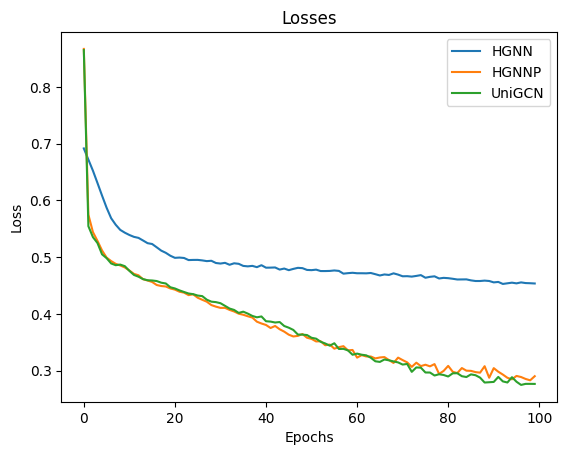

[('Base', {'HGNN': {'val_accuracy': 0.742222249507904, 'val_f1': 0.742222249507904, 'test_accuracy': 0.7333333492279053, 'test_f1': 0.7318022886204705}, 'HGNNP': {'val_accuracy': 0.7400000095367432, 'val_f1': 0.7400000095367432, 'test_accuracy': 0.699999988079071, 'test_f1': 0.6979580472428417}, 'UniGCN': {'val_accuracy': 0.7333333492279053, 'val_f1': 0.7333333492279053, 'test_accuracy': 0.7288888692855835, 'test_f1': 0.7279808149674966}}), ('With Densest Subgraphs', {'HGNN': {'val_accuracy': 0.753333330154419, 'val_f1': 0.753333330154419, 'test_accuracy': 0.7711111307144165, 'test_f1': 0.7671076630874438}, 'HGNNP': {'val_accuracy': 0.7377777695655823, 'val_f1': 0.7377777695655823, 'test_accuracy': 0.7400000095367432, 'test_f1': 0.7373737373737373}, 'UniGCN': {'val_accuracy': 0.742222249507904, 'val_f1': 0.742222249507904, 'test_accuracy': 0.742222249507904, 'test_f1': 0.7354497354497354}})]


<Figure size 1200x600 with 0 Axes>

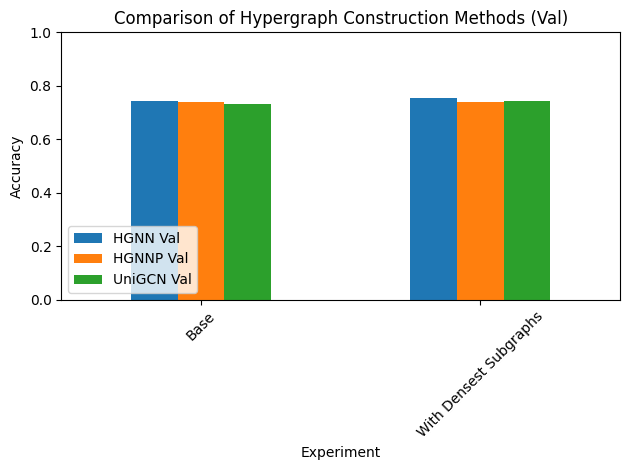

<Figure size 1200x600 with 0 Axes>

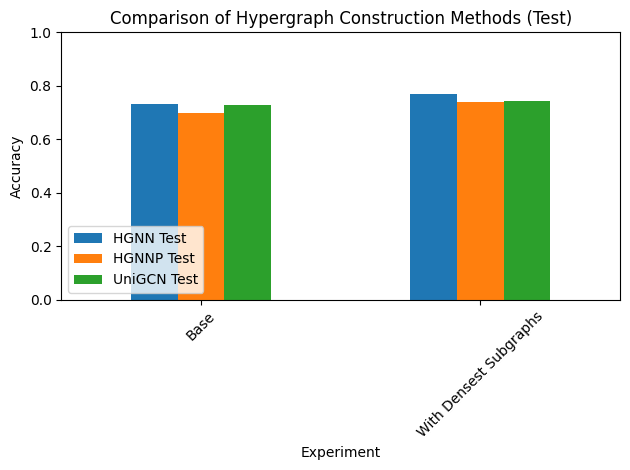


=== Results Summary Val ===
            Experiment  HGNN Val  HGNNP Val  UniGCN Val
                  Base  0.742222   0.740000    0.733333
With Densest Subgraphs  0.753333   0.737778    0.742222


=== Results Summary Test ===
            Experiment  HGNN Test  HGNNP Test  UniGCN Test
                  Base   0.733333        0.70     0.728889
With Densest Subgraphs   0.771111        0.74     0.742222


[('Base',
  {'HGNN': {'val_accuracy': 0.742222249507904,
    'val_f1': 0.742222249507904,
    'test_accuracy': 0.7333333492279053,
    'test_f1': 0.7318022886204705},
   'HGNNP': {'val_accuracy': 0.7400000095367432,
    'val_f1': 0.7400000095367432,
    'test_accuracy': 0.699999988079071,
    'test_f1': 0.6979580472428417},
   'UniGCN': {'val_accuracy': 0.7333333492279053,
    'val_f1': 0.7333333492279053,
    'test_accuracy': 0.7288888692855835,
    'test_f1': 0.7279808149674966}}),
 ('With Densest Subgraphs',
  {'HGNN': {'val_accuracy': 0.753333330154419,
    'val_f1': 0.753333330154419,
    'test_accuracy': 0.7711111307144165,
    'test_f1': 0.7671076630874438},
   'HGNNP': {'val_accuracy': 0.7377777695655823,
    'val_f1': 0.7377777695655823,
    'test_accuracy': 0.7400000095367432,
    'test_f1': 0.7373737373737373},
   'UniGCN': {'val_accuracy': 0.742222249507904,
    'val_f1': 0.742222249507904,
    'test_accuracy': 0.742222249507904,
    'test_f1': 0.7354497354497354}})]

In [373]:
movie_path = r'.\datasets\movie\movie_dataset.csv'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
evaluator = Evaluator(["accuracy", "f1_score", {"f1_score": {"average": "micro"}}])

experiment = HypergraphExperiment(
    data_path=movie_path
)
experiment.run_experiments(n_samples=3000)

experiment.results

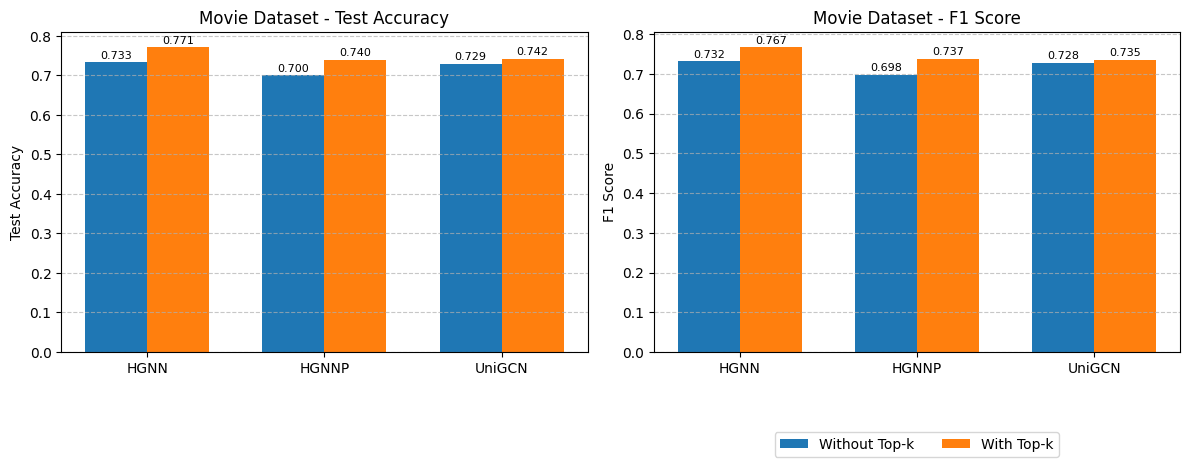

In [416]:
# Grouped bar chart for Movie dataset
def plot_movie_metrics(accuracy_data, f1_data):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    metrics = [("Test Accuracy", accuracy_data), ("F1 Score", f1_data)]
    groups = ['HGNN', 'HGNNP', 'UniGCN']
    variations = ['Base', 'With Densest Subgraphs']
    x = np.arange(len(groups))
    width = 0.35

    for ax, (metric_name, metric_data) in zip(axes, metrics):
        bars1 = ax.bar(x - width/2, [metric_data[model][0] for model in groups],
                       width=width, label='Without Top-k')
        bars2 = ax.bar(x + width/2, [metric_data[model][1] for model in groups],
                       width=width, label='With Top-k')

        # Annotate bar values
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                        f'{height:.3f}', ha='center', va='bottom', fontsize=8)

        ax.set_xticks(x)
        ax.set_xticklabels(groups)
        ax.set_ylabel(metric_name)
        ax.set_title(f'Movie Dataset - {metric_name}')
        ax.grid(axis='y', linestyle='--', alpha=0.7)

    axes[1].legend(loc='lower center', bbox_to_anchor=(0.5, -0.35), ncol=2)
    plt.tight_layout()
    plt.show()

plot_movie_metrics(accuracy_data, f1_data)
